# aiapy: A SunPy-Affiliated Package for Analyzing Data from the Atmospheric Imaging Assembly

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sunpy.net import Fido, attrs as a
import sunpy.map
import astropy.units as u
from astropy.coordinates import SkyCoord
import astropy.time
from astropy.visualization import time_support

from aiapy.calibrate import (register,update_pointing,correct_degradation,
                             degradation,normalize_exposure, respike, fetch_spikes)
from aiapy.response import Channel

Brief intro to the package plus list of additional resources (e.g. docs, GitLab)

Query 2-3 AIA images from different wavelengths and create `~sunpy.map.Map` objects.

In [2]:
t_start = astropy.time.Time('2012-01-01T00:00:00')

In [3]:
q = Fido.search(
    a.Time(t_start, t_start+11*u.s),
    a.Instrument('AIA'),
    a.Wavelength(171*u.angstrom) | a.Wavelength(335*u.angstrom),
)

In [4]:
f = Fido.fetch(q)

Files Downloaded: 100%|██████████| 2/2 [00:09<00:00,  4.68s/file]


In [5]:
m_171,m_335 = sunpy.map.Map(sorted(f))

## Point Spread Function Deconvolution (Optional?)
Needs a GPU

## Respiking Level 1 Images

In [6]:
m_171_respiked = respike(m_171)

In [7]:
pix, vals = fetch_spikes(m_171)

Text(0, 0.5, 'Frequency')

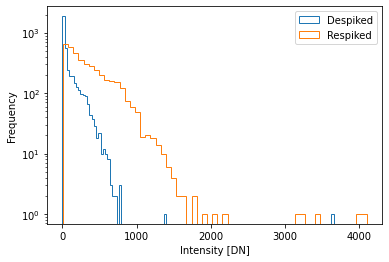

In [8]:
plt.hist(m_171.data[pix.y.value.round().astype(int),
                    pix.x.value.round().astype(int)].flatten(), log=True, bins='scott', histtype='step', label='Despiked');
plt.hist(vals, log=True, bins='scott', histtype='step', label='Respiked');
plt.legend()
plt.xlabel('Intensity [DN]')
plt.ylabel('Frequency')

In [9]:
m_171_cutout = m_171.submap(
    SkyCoord(-600*u.arcsec, -600*u.arcsec, frame=m_171.coordinate_frame),
    top_right=SkyCoord(100*u.arcsec, 100*u.arcsec, frame=m_171.coordinate_frame),
)

In [10]:
spike_coords, _ = fetch_spikes(m_171_cutout, as_coords=True)

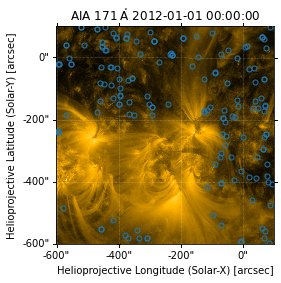

In [12]:
fig = plt.figure()
ax = fig.gca(projection=m_171_cutout)
ax.plot_coord(spike_coords, 'o', color='C0', fillstyle='none', markersize=5)
m_171_cutout.plot(axes=ax) 

## Transforming Level 1 Images to Level 1.5

Note about updating pointing information

In [13]:
m_171.reference_pixel

PixelPair(x=<Quantity 2052.530029 pix>, y=<Quantity 2046.130005 pix>)

In [14]:
m_171 = update_pointing(m_171)

In [15]:
m_171.reference_pixel

PixelPair(x=<Quantity 2052.003418 pix>, y=<Quantity 2044.915161 pix>)

Image ragistration

In [16]:
m_171.scale

SpatialPair(axis1=<Quantity 0.599489 arcsec / pix>, axis2=<Quantity 0.599489 arcsec / pix>)

In [17]:
m_171.rotation_matrix

array([[ 9.99999944e-01, -3.36028235e-04],
       [ 3.36028235e-04,  9.99999944e-01]])

In [18]:
m_171_lvl15 = register(m_171)

Note that you can combine these two operations into a "prep" function to imitate `aiaprep.pro`

In [19]:
def prep(smap):
    return register(update_pointing(smap))

In [20]:
m_335_lvl15 = prep(m_335)

In [21]:
print(m_171_lvl15.scale)
print(m_335_lvl15.scale)

SpatialPair(axis1=<Quantity 0.6 arcsec / pix>, axis2=<Quantity 0.6 arcsec / pix>)
SpatialPair(axis1=<Quantity 0.6 arcsec / pix>, axis2=<Quantity 0.6 arcsec / pix>)


In [22]:
print(m_171_lvl15.rotation_matrix)
print(m_335_lvl15.rotation_matrix)

[[ 1.00000000e+00 -2.06232805e-20]
 [-2.06232775e-20  1.00000000e+00]]
[[ 1.00000000e+00 -4.95971886e-20]
 [-4.83278058e-19  1.00000000e+00]]


## Degradation Correction

In [28]:
t_begin = astropy.time.Time('2010-03-25T00:00:00')
now = astropy.time.Time.now()
t = t_begin + np.arange(0, (now - t_begin).to(u.day).value, 7) * u.day

This function 

In [29]:
d_335 = degradation(335*u.angstrom, t)

We can also look at older versions of the calibration to see how the predicted degradation has changed. Note that the default version in `v0.3.0` of aiapy is 9.

In [30]:
d_335_v8 = degradation(335*u.angstrom, t, calibration_version=8)

And compare the two degradation curves as a function of time over the lifetime of the mission.

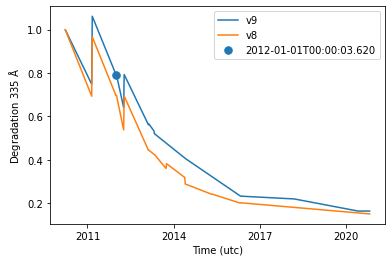

In [53]:
with time_support(format='jyear'):
    plt.plot(t,d_335,label='v9')
    plt.plot(t,d_335_v8,label='v8')
    plt.plot(m_335.date[np.newaxis], degradation(335*u.angstrom, m_335.date),
             linestyle='', marker='.', color='C0', markersize=15, label=m_335.date)
plt.ylabel('Degradation 335 $\mathrm{\AA}$')
plt.legend()

Note that we can pass an image into the `correct_degradation` function in order to correct the whole image.

In [33]:
m_335_corrected = correct_degradation(m_335)

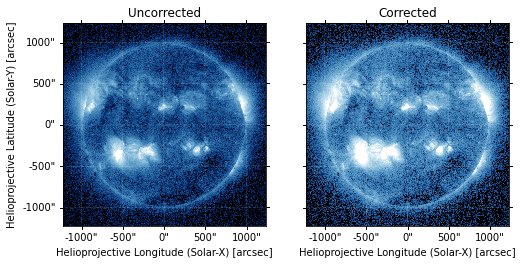

In [34]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(121,projection=m_335)
m_335.plot(axes=ax,vmin=0,vmax=200,title='Uncorrected')
ax = fig.add_subplot(122,projection=m_335_corrected)
m_335_corrected.plot(axes=ax,vmin=0,vmax=100,title='Corrected')
ax.coords[1].set_axislabel(' ')
ax.coords[1].set_ticklabel_visible(False)

## Exposure Time Normalization

In [47]:
m_171_lvl15.exposure_time

<Quantity 1.999598 s>

In [48]:
m_171_norm = normalize_exposure(m_171_lvl15)

In [49]:
m_171_norm.exposure_time

<Quantity 1. s>

## Wavelength Response Functions

Show that we can easily calculate the wavelenth response for a single channel, as well as the components of it, and then show all channels.

In [50]:
c = Channel(m_335.wavelength)

In [51]:
r = c.wavelength_response()
r_time = c.wavelength_response(obstime=m_335.date)
r_time_eve = c.wavelength_response(obstime=m_335.date, include_eve_correction=True)

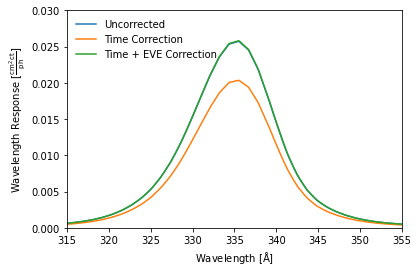

In [52]:
plt.plot(c.wavelength,r,label='Uncorrected')
plt.plot(c.wavelength,r_time,label='Time Correction')
plt.plot(c.wavelength,r_time_eve,label='Time + EVE Correction')
plt.xlim([315,355])
plt.ylim([0,0.03])
plt.xlabel('Wavelength [$\mathrm{\AA}$]')
plt.ylabel(f'Wavelength Response [{r.unit.to_string(format="latex")}]')
plt.legend(frameon=False)

Some final concluding text